# Trotter-Suzuki

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, IBMQ, Aer
from qiskit.circuit import Parameter
from qiskit.test.mock import FakeVigo, FakeMelbourne, FakeTokyo
from qiskit.visualization import plot_circuit_layout, plot_gate_map, plot_histogram, plot_state_paulivec, plot_bloch_multivector
from qiskit.providers.models import BackendConfiguration

In [6]:
#import qiskit
#qiskit.__qiskit_version__

C:\Users\Melissa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


{'qiskit-terra': '0.18.1', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.4', 'qiskit': '0.29.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

## Circuito base
En la siguiente función, definiendo el valor de $n$, generamos un circuito parametrizado de Trotter-Suzuki.

In [2]:
def trotter_suzuki(n):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    qc = QuantumCircuit(qr,cr)
    parameter_theta = Parameter('θ')
    parameter_phi = Parameter('ϕ')
    for i in range(n):
        qc.rz(parameter_theta, qubit=0)
        qc.rz(parameter_theta, qubit=1)
        qc.rxx(parameter_phi,qubit1=0,qubit2=1)
    return qc

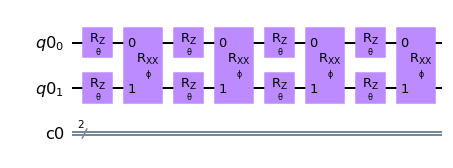

In [3]:
n = 4
ts1 = trotter_suzuki(n)
ts1.draw('mpl')

In [4]:
print(ts1.parameters)

ParameterView([Parameter(θ), Parameter(ϕ)])


## Posible optimización
Transpilando el circuito de tres compuertas de arriba hacia compuertas para ejecutarlo con las compuertas base de un computador cuántico, simulamos con los mock backends de IBM.

### ibmq_vigo
En el caso de IBMQ Vigo, con la siguiente mapa de qubits, el transpilador no encuentra optimizaciones en el circuito más allá de la primera transpilación, sin embargo, podría funcionar la combinación manual de las dos primeras compuertas $R_Z(\theta)$ y $R_Z(\frac{\pi}{2})$ en una sola $R_Z(\theta+\frac{\pi}{2})$, reduciendo en 2 compuertas por cada $n$.

In [5]:
def show_gates(backend):
    config = backend.configuration()
    print("Las compuertas de {0} son {1}.".format(config.backend_name, config.basis_gates))

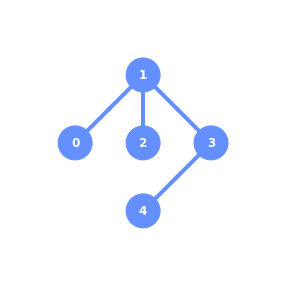

In [6]:
vigo = FakeVigo()
plot_gate_map(vigo)

In [7]:
show_gates(vigo)

Las compuertas de fake_vigo son ['id', 'rz', 'sx', 'x', 'cx'].


#### Sin optimización del transpilador

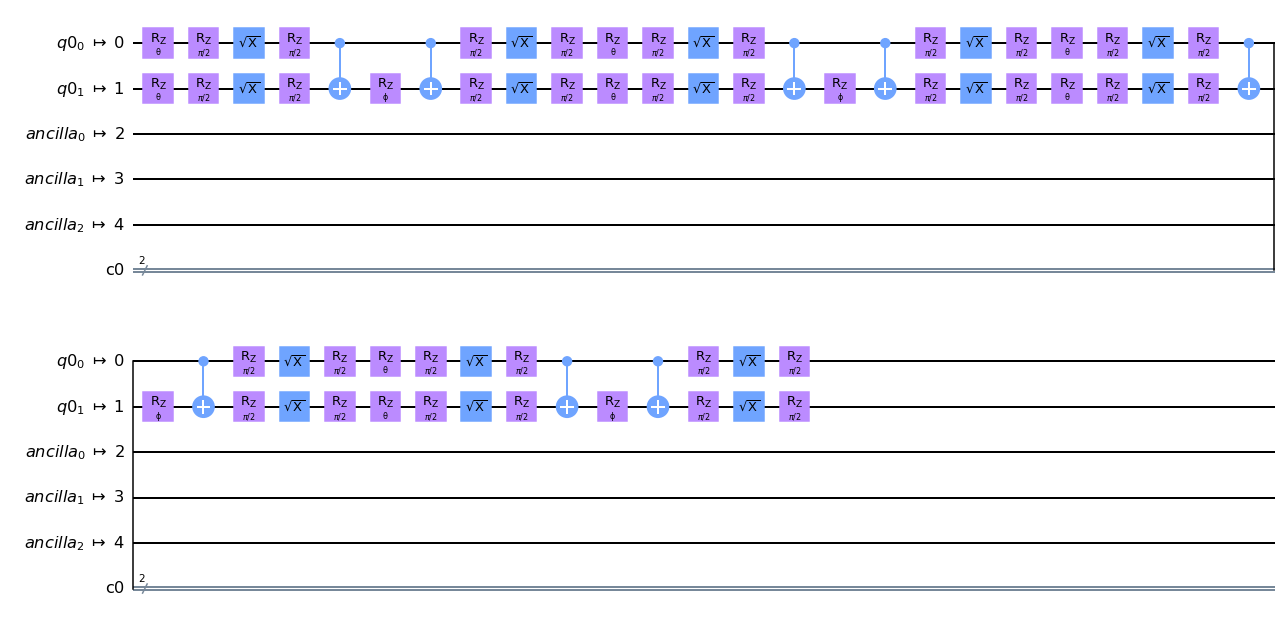

In [8]:
transpiled = transpile(ts1, backend=vigo, optimization_level=0)
plot_circuit_layout(transpiled, vigo)
transpiled.draw(output='mpl')

#### Con optimización nivel 3 del transpilador

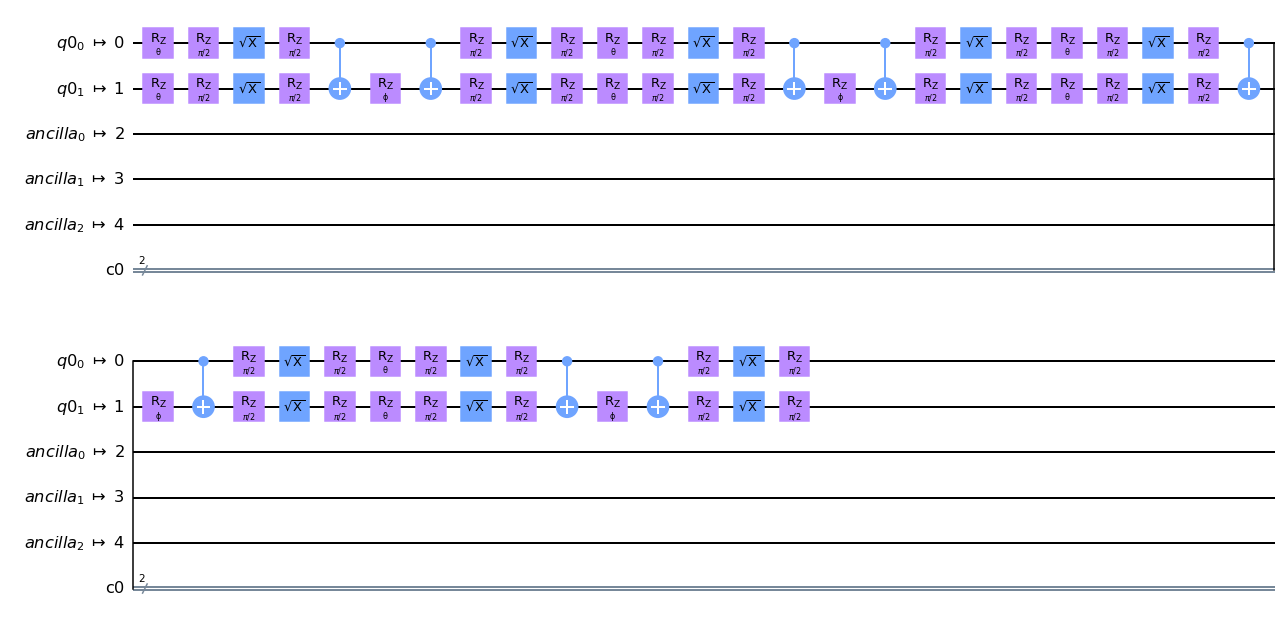

In [9]:
transpiled_opt = transpile(ts1, backend=vigo, optimization_level=3)
plot_circuit_layout(transpiled_opt, vigo)
transpiled.draw(output='mpl')

### ibmq_tokyo
IBMQ Tokyo tiene 20 qubits, y en este caso el mapa de qubits y las compuertas base son diferentes, teniendo que este computador funciona en base a compuertas de rotación $U$, aplicando las rotaciones directamente a cada eje. Ojo, que el Tokyo real fue dado de baja y es posible que FakeTokyo sea removido de Qiskit algún día.

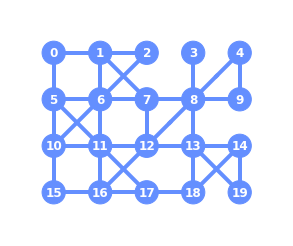

In [10]:
tokyo = FakeTokyo()
plot_gate_map(tokyo)

In [11]:
show_gates(tokyo)

Las compuertas de fake_tokyo son ['u1', 'u2', 'u3', 'cx', 'id'].


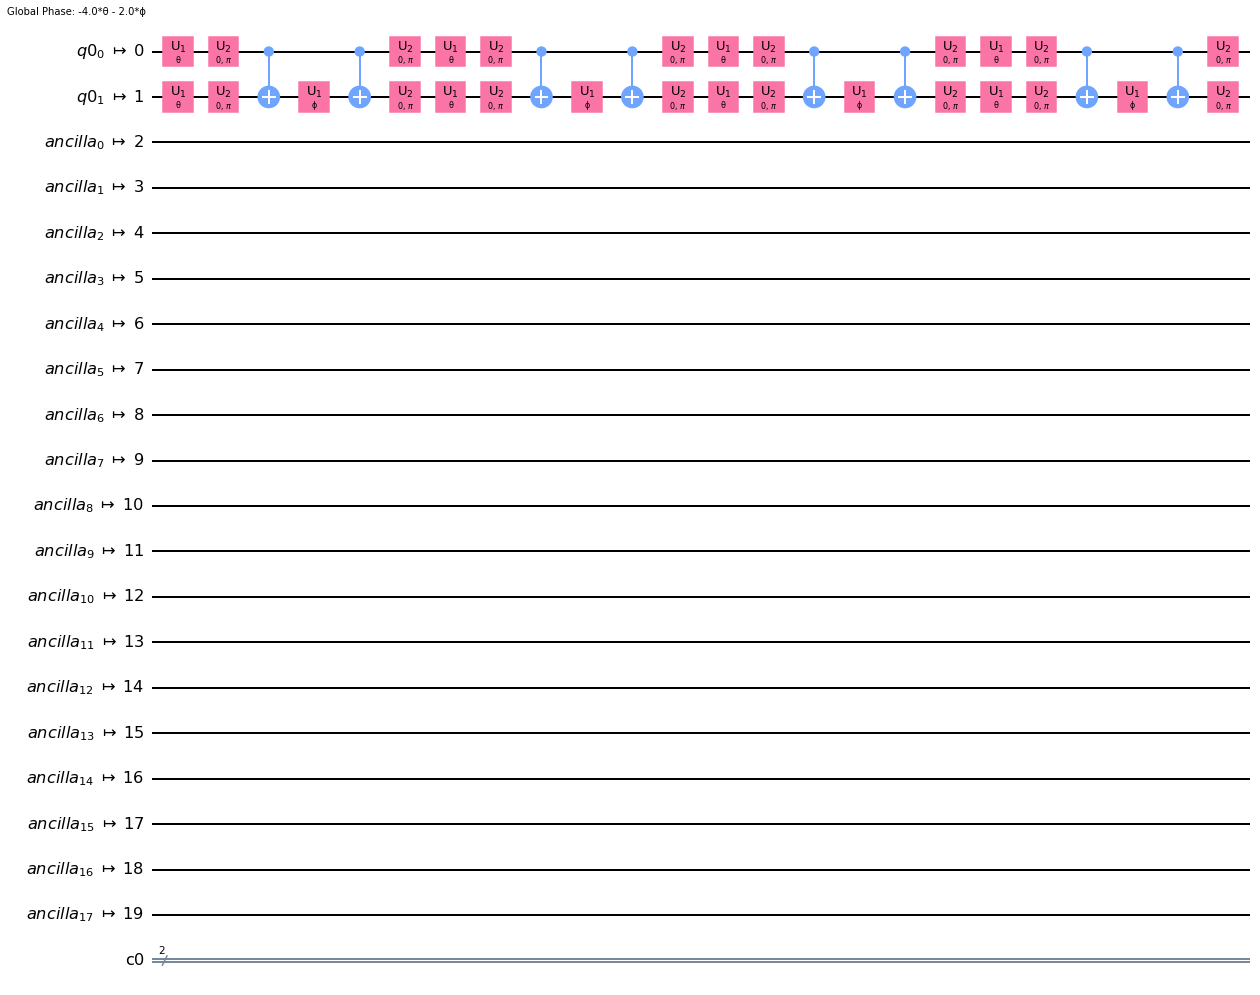

In [12]:
transpiled = transpile(ts1, backend=tokyo, optimization_level=0)
plot_circuit_layout(transpiled, tokyo)
transpiled.draw(output='mpl')

## Asignación de parámetros y medición

### Importante
Tener en consideración que, para Qiskit, las compuertas que estamos usando son así:
#### RXX

$$
        R_{XX}(\theta) = exp(-i \frac{\theta}{2} X{\otimes}X) =
            \begin{pmatrix}
                \cos(\frac{\theta}{2})   & 0           & 0           & -i\sin(\frac{\theta}{2}) \\
                0           & \cos(\frac{\theta}{2})   & -i\sin(\frac{\theta}{2}) & 0 \\
                0           & -i\sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2})   & 0 \\
                -i\sin(\frac{\theta}{2}) & 0           & 0           & \cos(\frac{\theta}{2})
            \end{pmatrix}
$$
Fuente: <https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html>

#### RZ
$$
RZ(\lambda) = exp(-i\frac{\lambda}{2}Z) =
            \begin{pmatrix}
                e^{-i\frac{\lambda}{2}} & 0 \\
                0 & e^{i\frac{\lambda}{2}}
            \end{pmatrix}
$$
Fuente: <https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html>

In [13]:
#param_dict = {Parameter('θ'): 3.1416/4, Parameter('ϕ'):0.1}
def bound_trotter_suzuki(parameterized_trotter_suzuki, theta, phi):
    parameters = {theta, phi}
    bound_circuit = parameterized_trotter_suzuki.bind_parameters(parameters)
    return bound_circuit

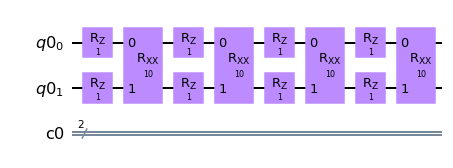

In [14]:
bound_circuit = bound_trotter_suzuki(ts1, 1, 10)
bound_circuit.draw('mpl')

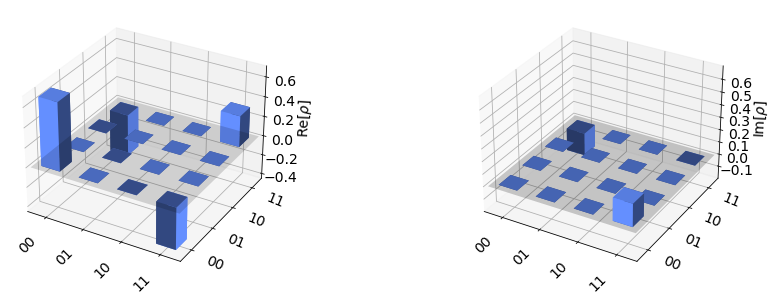

In [15]:
from qiskit.tools.visualization import plot_state_city
simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(bound_circuit).result()
statevector = result.get_statevector(bound_circuit)
plot_state_city(statevector)

In [16]:
backend = Aer.get_backend('statevector_simulator')
result = backend.run(transpile(bound_circuit, backend)).result()
psi  = result.get_statevector(bound_circuit)

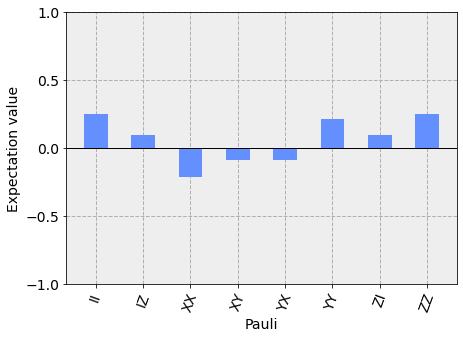

In [17]:
plot_state_paulivec(psi)

C:\Users\Melissa\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


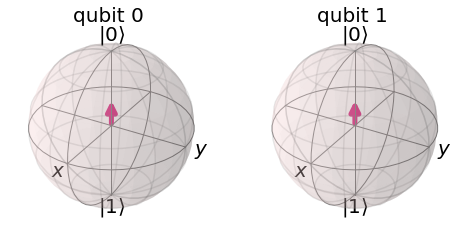

In [18]:
plot_bloch_multivector(psi)

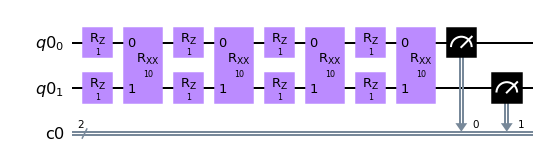

In [19]:
bound_circuit.measure(0,0)
bound_circuit.measure(1,1)
bound_circuit.draw('mpl')

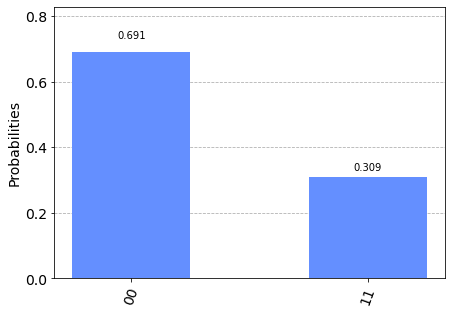

In [20]:
simulator = Aer.get_backend('aer_simulator')
result = simulator.run(bound_circuit).result()
counts = result.get_counts(bound_circuit)
plot_histogram(counts)
